In [6]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import math
import numpy as np
import matplotlib.pyplot as plt

%env OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_3/opt/oommf/oommf.tcl

env: OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_3/opt/oommf/oommf.tcl


In [7]:
mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
Ms    = 0.84e6               # saturation magnetisation        A/m
A     = 10e-12              # exchange coupling strength      J/m
Km    = mu0 * Ms**2     # magnetostatic energy density    kg/ms^2
lexch = (A/Km)**0.5   
Rcoey = (24)**0.5*lexch #needle
print(Ms)
print(lexch)
print(Rcoey)

840000.0
3.3582713306414063e-09
1.645210235577788e-08


In [8]:
K = 0.15e3  # cubic anisotropy constant (J/m**3)
u1 = (0, 0, 1)  # cubic anisotropy axis
u2 = (0, 1, 0)  # cubic anisotropy axis

In [19]:
N = 16
r = 3*lexch  #  6*lex and 10* lex
cellsize = r/N  # discretisation in all three dimensions.
p1 = (-r, -r, -r)  # Minimum sample coordinate.
p2 = (r/2, r, r)  # Maximum sample coordinate.
cell = (cellsize, cellsize, cellsize)  # Discretisation.
mesh = df.Mesh(p1=p1, p2=p2, cell=(cellsize, cellsize, cellsize))  # Create a mesh object.
flower_init = (0, 0, 1)
def vortex_init(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    rho = x**2 + y**2
    phi = math.atan(x/y)
    b = 2*lexch
    m_phi = np.sin(2 * np.arctan(rho/b))
    return np.array([-m_phi*np.sin(phi), m_phi*np.cos(phi) , np.sqrt(1.0 - m_phi**2)])

def Ms_value(pos):
    x, y, z =  pos
    if x**2 + y**2  < (r)**2:
        return Ms
    else:
        return 0
    
print(cellsize)
print(r)

6.296758744952637e-10
1.0074813991924219e-08


In [20]:
system = mm.System(name='NiFe')


gamma0 = 0  # gyromagnetic ratio (m/As)
alpha = 0.02  # Gilbert damping

system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

system.energy = mm.Exchange(A=A) + mm.CubicAnisotropy(K=K, u1=u1, u2=u2) + mm.Demag()+mm.Zeeman(H=(0, 0, 0))
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms_value)

evolve = oc.CGEvolver()
md = oc.MinDriver(stopping_mxHxm=0.01)


B1_array = np.arange(-2, +2, 0.06)
B2_array = np.arange(0.3, -0.3, -0.01)
B_array =  np.append([B1_array], [B2_array])

mz = []
mx = []
my = []
S = []
S1 = []
S2 = []

for B in B2_array:
    # Marijan: This way we update the field.
    system.energy.zeeman.H = (0, 0, B/mm.consts.mu0)
    md.drive(system)
    # Marijan: A bit more cool way to extract the x-average normalised magnetisation :)
    mz.append(system.m.orientation.z.average)
    mx.append(system.m.orientation.x.average)
    my.append(system.m.orientation.y.average)
    m = system.m.orientation.plane(z=0.5*r)
    m1 = system.m.orientation.plane(x=0.5*r)
    m2 = system.m.orientation.plane(y=0.5*r)
    S.append(df.integral(m @ (m.derivative('x') & m.derivative('y')) * df.dx*df.dy) / 4 / 3.14)
    S1.append(df.integral(m1 @ (m1.derivative('y') & m1.derivative('z')) * df.dx*df.dy) / 4 / 3.14)
    S2.append(df.integral(m2 @ (m2.derivative('z') & m2.derivative('x')) * df.dx*df.dy) / 4 / 3.14)

Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (4.4 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.2 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.1 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/10 09:37]... (3.0 s)
Running OOMMF (ExeOOMMFRunner)[2023/10/1

Text(0, 0.5, 'Q')

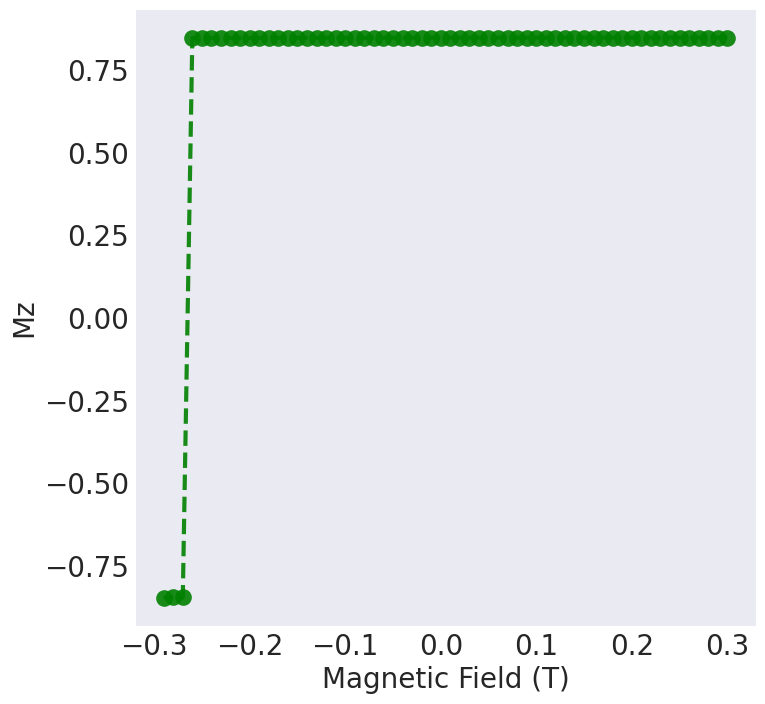

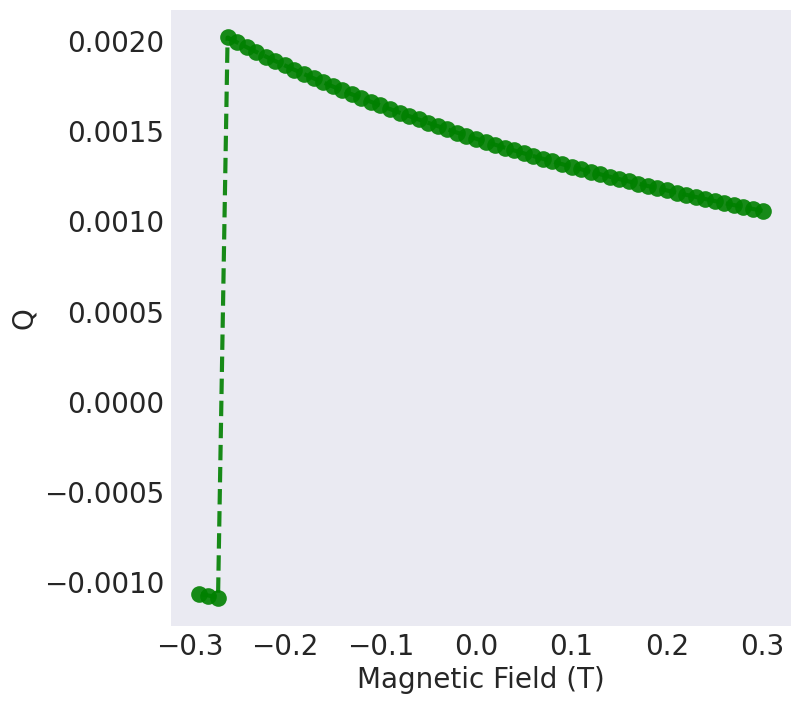

In [21]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array, mz, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

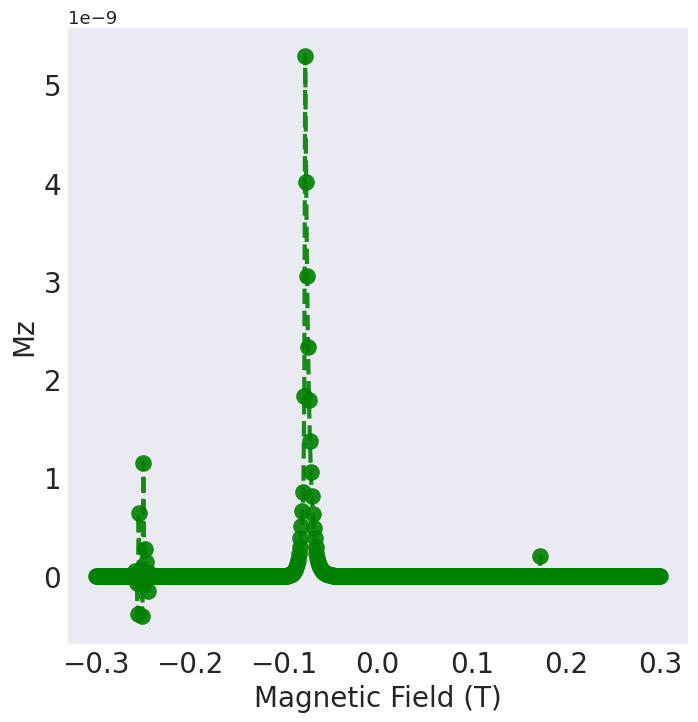

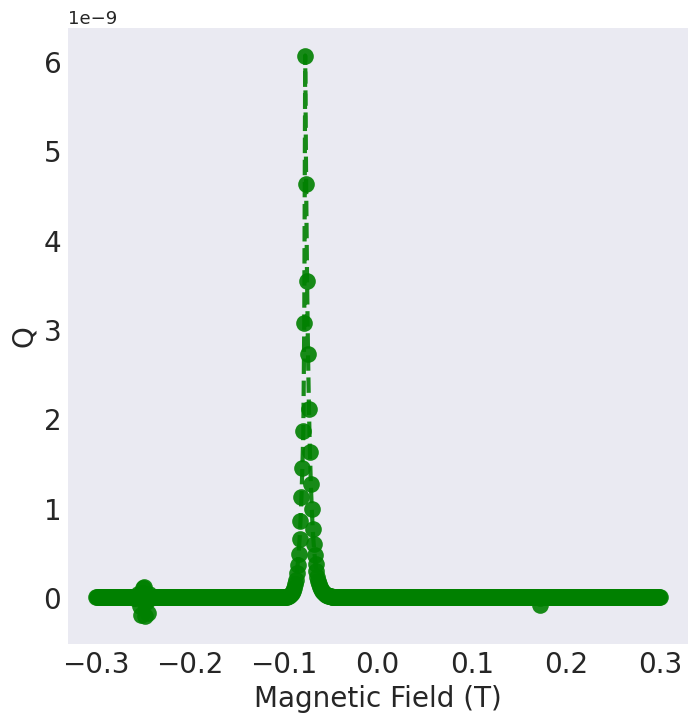

In [11]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mx, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S1, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

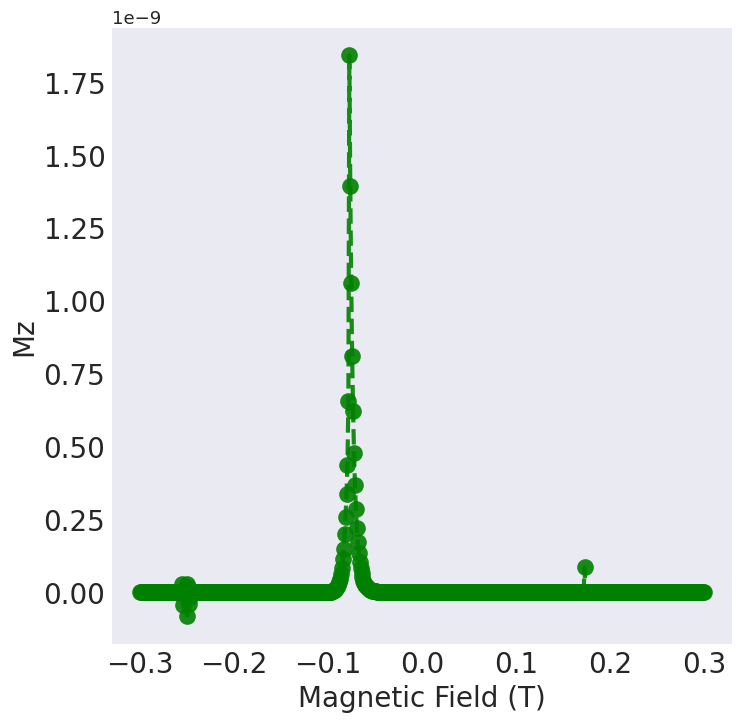

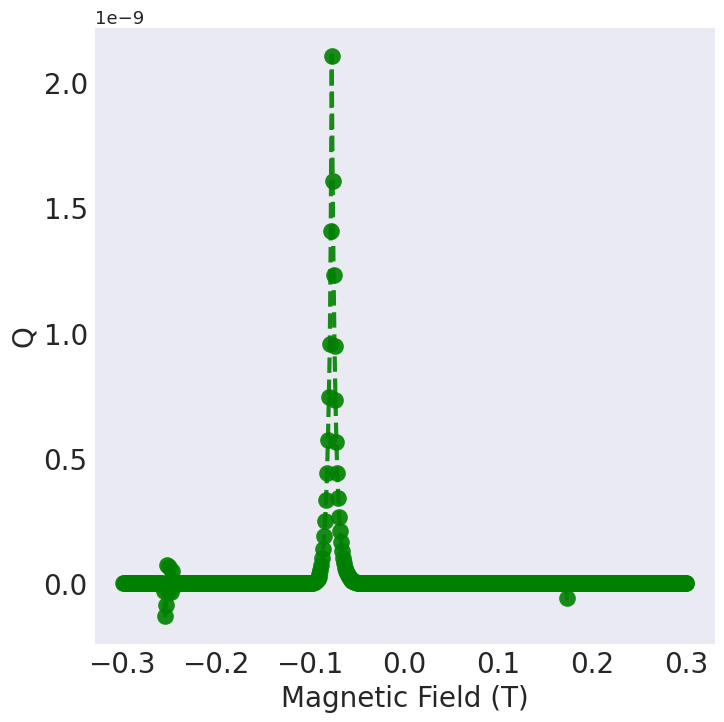

In [12]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,my, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S2, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

In [23]:
print(S)

[0.00045728120417921594, 0.0004582538081925402, 0.00045922983426089926, 0.0004602093033935121, 0.00046119223130344143, 0.0004621786367465909, 0.00046316853742100236, 0.0004641619491770188, 0.0004651588901439166, 0.00046615937819177917, 0.00046716343226530107, 0.0004681710693319549, 0.0004691823067823096, 0.0004701971633849187, 0.00047121565738294407, 0.000472237807832733, 0.0004732636330446935, 0.0004742931511870257, 0.0004753263813120302, 0.00047636334243917, 0.00047740405300698304, 0.0004784485334353886, 0.00047949680203045316, 0.00048054887827385487, 0.00048160478230399335, 0.000482664533278156, 0.0004837281504051146, 0.0004847956546462668, 0.0004858670662462045, 0.00048694240472621996, 0.0004880216904990635, 0.0004891049442360277, 0.0004901921866292362, 0.0004912834368141742, 0.0004923787186385682, 0.0004934780535506224, 0.0004945814575126129, 0.0004956889563748806, 0.0004968005717740229, 0.0004979163218345709, 0.0004990362317136198, 0.0005001603220347482, 0.0005012886150658238, 0.

In [24]:
print(mz)

[0.5264969262609556, 0.5264966593227227, 0.5264963913680591, 0.5264961223904951, 0.5264958523847127, 0.5264955813452419, 0.5264953092666224, 0.5264950361434384, 0.526494761970133, 0.526494486741136, 0.526494210450847, 0.5264939330936126, 0.5264936546638168, 0.5264933751557426, 0.5264930945635967, 0.5264928128816195, 0.5264925301039762, 0.5264922462247915, 0.5264919612381785, 0.5264916751381598, 0.5264913879188113, 0.5264910995739853, 0.5264908100977411, 0.5264905194838898, 0.5264902277262846, 0.5264899348187414, 0.5264896407550484, 0.5264893455288848, 0.526489049133945, 0.5264887515638298, 0.526488452812146, 0.526488152872465, 0.5264878517382053, 0.5264875494029109, 0.5264872458599281, 0.5264869411026358, 0.5264866351243325, 0.5264863279183373, 0.5264860194778483, 0.5264857097959603, 0.5264853988658875, 0.5264850866806895, 0.5264847732333516, 0.5264844585169509, 0.5264841425242947, 0.526483825248328, 0.5264835066818498, 0.5264831868176827, 0.5264828656484822, 0.5264825431669623, 0.5264

In [21]:
B2 = B2_array.tolist()

In [22]:
print(B2)

[0.3, 0.299, 0.298, 0.297, 0.296, 0.295, 0.294, 0.293, 0.292, 0.291, 0.29, 0.289, 0.288, 0.287, 0.286, 0.285, 0.284, 0.283, 0.282, 0.28099999999999997, 0.27999999999999997, 0.27899999999999997, 0.27799999999999997, 0.27699999999999997, 0.27599999999999997, 0.27499999999999997, 0.27399999999999997, 0.27299999999999996, 0.27199999999999996, 0.27099999999999996, 0.26999999999999996, 0.26899999999999996, 0.26799999999999996, 0.26699999999999996, 0.26599999999999996, 0.26499999999999996, 0.26399999999999996, 0.26299999999999996, 0.26199999999999996, 0.26099999999999995, 0.25999999999999995, 0.25899999999999995, 0.25799999999999995, 0.25699999999999995, 0.25599999999999995, 0.25499999999999995, 0.25399999999999995, 0.25299999999999995, 0.25199999999999995, 0.25099999999999995, 0.24999999999999994, 0.24899999999999994, 0.24799999999999994, 0.24699999999999994, 0.24599999999999994, 0.24499999999999994, 0.24399999999999994, 0.24299999999999994, 0.24199999999999994, 0.24099999999999994, 0.239999